# Generative Adversarial Networks for Artistic Style Transfer: From Photo to Monet

### **1. Introduction**

#### **1.1. Problem Statement**

The primary objective of this project is to address the image-to-image translation task presented in the "I'm something of a painter myself" Kaggle competition. The goal is to build a model that can take a standard photograph as input and render it in the artistic style of the French Impressionist painter Claude Monet. This task falls under the domain of artistic style transfer, a challenging area of computer vision that aims to separate and recombine the content of one image with the style of another.

You can find the code of this report here: https://github.com/jjzd83/IDL-wk5.

#### **1.2. Background**

Generative Adversarial Networks (GANs) have emerged as a powerful tool for generative modelling. However, standard GANs often require paired datasets, where a direct one-to-one correspondence exists between input and target images. For artistic style transfer, such paired data is rarely available; we do not have photographs and their corresponding Monet painting equivalents.

To overcome this limitation, we employ a Cycle-Consistent Generative Adversarial Network (CycleGAN). A CycleGAN learns the mapping between two distinct image domains—in this case, photographs and Monet paintings—without the need for paired examples. It achieves this through a cycle-consistency loss, which ensures that if an image is translated from domain A to domain B and then back to A, the resulting image should be close to the original. This makes CycleGAN an ideal architecture for this problem.


### **1.3. Dataset**

The dataset for this project is sourced from the "GANs Getting Started" Kaggle competition and comprises two distinct, unpaired image domains.

* **Image Domains**: The data is organised into two primary collections:
    * **Monet Paintings**: 300 images of paintings by Claude Monet.
    * **Photographs**: 7,038 landscape photographs.

* **Format and Structure**: For efficient model training, the images are provided in the TFRecord binary format. Each TFRecord file acts as a container for multiple images. While raw JPEG files are available, the model training will primarily use the TFRecord version.

* **Image Properties**: All images in the dataset are standardised to a resolution of **256x256 pixels** and contain three **RGB colour channels**.



### **2. Data and Exploratory Data Analysis (EDA)**

#### **2.1. Setup and imports**

This section imports the required libraries for data handling, model building, and visualisation. It also defines key configuration variables that will be used throughout the notebook.


In [ ]:
# --- [1] Setup and Imports ---

import os
import random
import csv
import glob
import shutil
import datetime
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import PIL

# --- [2] Hardware and Strategy Configuration ---
strategy = tf.distribute.MirroredStrategy()
print(f"TensorFlow Version: {tf.__version__}")
print(f"Number of replicas for distributed training: {strategy.num_replicas_in_sync}")

# --- [3] Global Constants and Hyperparameters ---
# Data pipeline configuration
DATA_PATH = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = glob.glob(DATA_PATH + '/monet_tfrec/*.tfrec')
PHOTO_FILENAMES = glob.glob(DATA_PATH + '/photo_tfrec/*.tfrec')

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 1000 # Buffer for shuffling the dataset
BATCH_SIZE_PER_REPLICA = 1
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Model training hyperparameters
EPOCHS = 25
LEARNING_RATE = 2e-4
LAMBDA_CYCLE = 10.0 # Weight for the cycle-consistency loss

KERNEL_INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Session/Environment configuration 
INTERACTIVE_SESSION = False # Prevent's retraining of model

# --- [4] Utility Functions ---

def set_seed(seed=42):
    """
    Sets random seeds for reproducibility of runs in TensorFlow, NumPy, and Python.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- [5] Initial Execution ---

# Set the seed for a reproducible run
set_seed()

#### **2.2. Data Preprocessing**

A standardised preprocessing pipeline was established to prepare the data for training. First, the JPEG images stored within the TFRecord files were decoded. Subsequently, the pixel values of each image, which are initially in the range [0, 255], were normalised to the range [-1, 1]. This normalisation is essential as the generator's final activation function is the hyperbolic tangent (tanh), which outputs values in this same range, ensuring consistency between the generated output and the training data.

The following functions define the complete preprocessing pipeline, from parsing TFRecord files to optimising the dataset for performance.


In [ ]:
def decode_image(image):
    """Decodes a JPEG-encoded image string and normalizes it to [-1, 1]."""
    image = tf.image.decode_jpeg(image, channels=OUTPUT_CHANNELS)
    # Normalize pixel values from [0, 255] to [-1, 1] to match the generator's tanh output.
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, OUTPUT_CHANNELS])
    return image

def read_tfrecord(example):
    """Parses a single TFRecord example and extracts the decoded image."""
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    """Creates a tf.data.Dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def configure_for_performance(ds):
    """Optimizes a dataset for training with caching, shuffling, batching, and prefetching."""
    ds = ds.cache()
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(GLOBAL_BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

#### **2.3. Dataset Instantiation**
With the pipeline functions defined, we now instantiate the datasets for both Monet paintings and photographs. These `tf.data.Dataset` objects are now fully prepared for the training loop.

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES)
monet_ds = configure_for_performance(monet_ds)

photo_ds = load_dataset(PHOTO_FILENAMES)
photo_ds = configure_for_performance(photo_ds)

print("Monet Dataset:", monet_ds)
print("Photo Dataset:", photo_ds)

#### **2.4. Exploratory Visualisation**

#### **Visual Inspection**
To establish a baseline, we visualised samples from the input (photo) and target (Monet) domains. This initial check defines the required transformation.

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Use plt.subplots() for better control over the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# --- Input Domain: Photo ---
ax[0].imshow(example_photo[0] * 0.5 + 0.5) # Denormalize for display
ax[0].set_title('Input Domain (Photo)', fontsize=14)
ax[0].axis('off') # Hide axes for clarity

# --- Target Domain: Monet ---
ax[1].imshow(example_monet[0] * 0.5 + 0.5) # Denormalize for display
ax[1].set_title('Target Domain (Monet)', fontsize=14)
ax[1].axis('off') # Hide axes for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

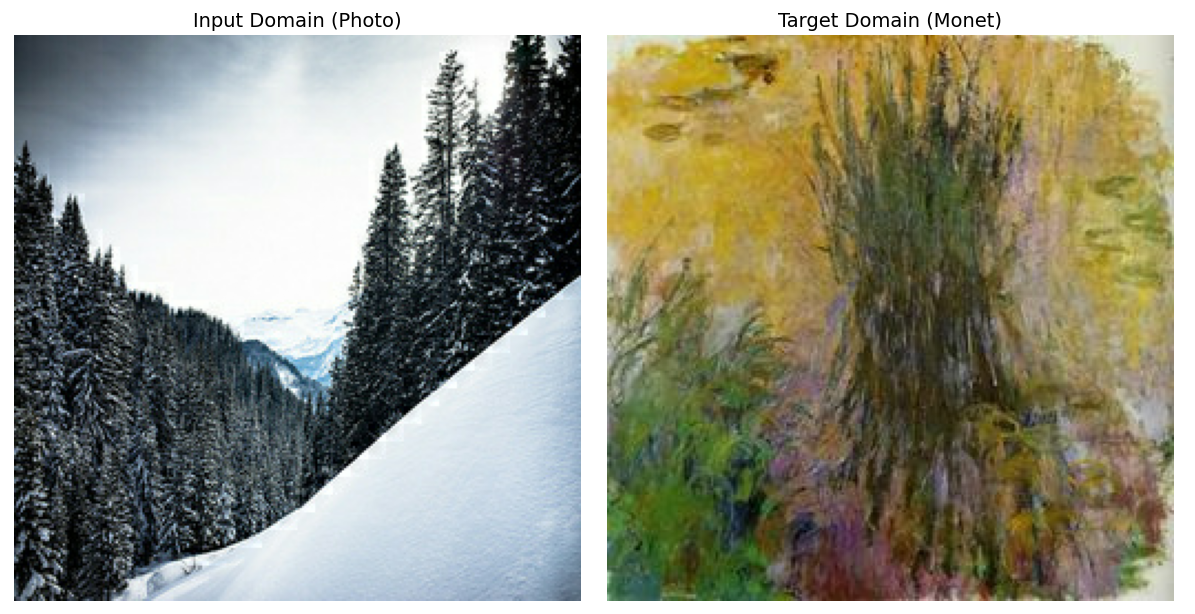

*Figure 1*: Example images from the dataset. Left column: Sample photograph. Right column: Sample Monet painting.


#### **Colour Distribution Analysis**

To quantify the colour palette differences, we plotted the distribution of pixel intensities for the RGB channels.

Based on our visual inspection, we anticipate significant differences between the two distributions. The histograms for the photo domain are expected to be broad and relatively uniform, indicating the use of a full, high-fidelity colour spectrum. In contrast, we predict the histograms for the Monet domain will be narrower and show distinct peaks, quantifying his characteristic palette (e.g., prominent blues and greens) and his typical avoidance of pure black and white.

The following code generates the histograms to test this assumption.

In [ ]:
def plot_color_histograms(ds, title, sample_size=100):
    """Samples images from a dataset and plots the RGB channel histograms."""
    r_vals, g_vals, b_vals = [], [], []
    for image_batch in ds.take(sample_size):
        img = (image_batch[0].numpy() * 127.5 + 127.5).astype(np.uint8)
        r_vals.extend(img[:, :, 0].flatten())
        g_vals.extend(img[:, :, 1].flatten())
        b_vals.extend(img[:, :, 2].flatten())

    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14)
    plt.hist(r_vals, bins=256, color='red', alpha=0.6, label='Red Channel', density=True)
    plt.hist(g_vals, bins=256, color='green', alpha=0.6, label='Green Channel', density=True)
    plt.hist(b_vals, bins=256, color='blue', alpha=0.6, label='Blue Channel', density=True)
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Density')
    plt.xlim([0, 256])
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- Generate and Display Histograms ---
plot_color_histograms(photo_ds, "RGB Histograms: Photo Domain")
plot_color_histograms(monet_ds, "RGB Histograms: Monet Domain")

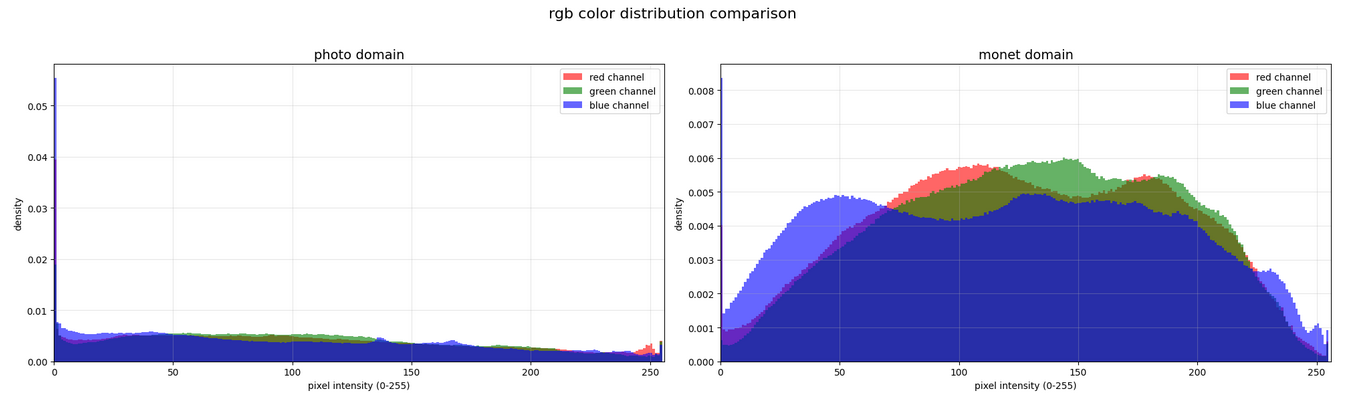
*Figure 2*: Comparison of RGB color channel distributions. The photo domain (left) shows broad, uniform distributions, while the Monet domain (bottom) shows broad and shifted towards mid-range intensities, with a clear avoidance of pure black and white values.

This analysis concludes the main part of our EDA. We have inspected the data, visualized it, and quantified a key difference, providing a foundation for the modeling phase.



### **3. Model Architecture**

#### **3.1. Core Concept: Cycle-Consistent Adversarial Networks (CycleGAN)**
For the task of unpaired image-to-image translation, we selected a **Cycle-Consistent Adversarial Network (CycleGAN)**. This architecture is specifically designed for problems where a direct pairing between input and target images is unavailable. The core of the system consists of two main components operating in tandem: two **Generators** and two **Discriminators**. One generator learns the mapping from photographs to the Monet style ($G_{Photo \rightarrow Monet}$), while the second learns the inverse mapping ($G_{Monet \rightarrow Photo}$). Each generator is paired with a discriminator whose task is to distinguish between real images in the target domain and the images created by its generator. This dual-generator, dual-discriminator setup is the foundation of our approach.

### **3.2. The Generator: A ResNet-based Architecture**

#### **3.2.1. Downsampling and Upsampling Blocks**

The generator is built from several modular blocks. The first are the downsampling and upsampling blocks, which handle the encoding and decoding phases. For the upsampling block, we use a combination of `UpSampling2D` and a standard `Conv2D` layer. This is a deliberate choice to help prevent the "checkerboard artefacts" that can sometimes be produced by transposed convolutions.



In [ ]:
def downsample(filters, size, apply_norm=True):
    """Downsamples the input using a strided convolution."""
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=KERNEL_INITIALIZER, use_bias=False)
    )
    if apply_norm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=KERNEL_INITIALIZER))
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsamples the input, avoiding checkerboard artifacts."""
    result = tf.keras.Sequential()
    result.add(
        # Use UpSampling2D followed by Conv2D
        tf.keras.layers.UpSampling2D(size=2, interpolation='nearest')
    )
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                               kernel_initializer=KERNEL_INITIALIZER, use_bias=False)
    )
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=KERNEL_INITIALIZER))
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

#### **3.2.2. The Residual Block**

The core of our generator's transformation phase is the residual block (ResNet block). A deep stack of these blocks allows the model to learn complex transformations. Each block contains two convolutional layers and a "skip connection," which adds the input of the block to its output. This technique helps combat the vanishing gradient problem in very deep networks, making them easier to train.

In [ ]:
def resnet_block(n_filters, input_layer):
    """
    Defines a standard ResNet block with two convolutional layers and a skip connection.
    """
    # Initialize the first convolutional layer
    g = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', 
                               kernel_initializer=KERNEL_INITIALIZER)(input_layer)
    g = tfa.layers.InstanceNormalization(gamma_initializer=KERNEL_INITIALIZER)(g)
    g = tf.keras.layers.ReLU()(g)
    
    # Second convolutional layer
    g = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', 
                               kernel_initializer=KERNEL_INITIALIZER)(g)
    g = tfa.layers.InstanceNormalization(gamma_initializer=KERNEL_INITIALIZER)(g)
    
    # Add the input (skip connection) to the output of the block
    g = tf.keras.layers.Add()([g, input_layer])
    
    return g

#### **3.2.3. Assembling the Generator and Initial State**
With all the building blocks defined (`downsample`, `upsample`, `resnet_block`), we can now assemble the complete generator. The model comprises an encoder, a transformer phase consisting of a variable number of ResNet blocks, and a decoder.

Finally, we instantiate the model and visualise its output on a sample image to confirm its initial, untrained state is random noise.

In [ ]:
def ResNetGenerator(n_resnet_blocks=6):
    """
    Builds the ResNet generator model.
    """
    inputs = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
    x = inputs

    # Encoder
    x = downsample(64, 4, apply_norm=False)(x) # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)                   # (bs, 64, 64, 128)

    # Transformer
    for _ in range(n_resnet_blocks):
        x = resnet_block(128, x)

    # Decoder
    x = upsample(64, 4)(x)                       # (bs, 128, 128, 64)
    x = upsample(32, 4)(x)                       # (bs, 256, 256, 32)

    # Final layer to produce the 3-channel output image
    x = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, padding='same', 
                               kernel_initializer=KERNEL_INITIALIZER, 
                               activation='tanh')(x)   # (bs, 256, 256, 3)

    return tf.keras.Model(inputs=inputs, outputs=x)

# --- Visualize the output of the untrained generator ---
untrained_monet_generator = ResNetGenerator()

# Pass a sample photo through the untrained generator
input_photo = next(iter(photo_ds))
prediction = untrained_monet_generator(input_photo, training=False)

# Display the input, the noisy prediction
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(prediction[0] * 0.5 + 0.5)
plt.show()

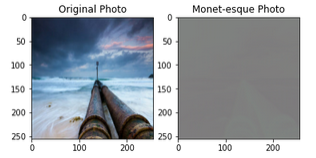

*Figure 3*: Visual baseline of the generator's initial state.

### **3.3. The Discriminator: PatchGAN** 🕵️

The discriminator's role is to distinguish between real images from the target domain and the "fake" images created by the generator. Instead of a standard discriminator that outputs a single score for the entire image, we use a **PatchGAN** architecture.

A PatchGAN classifies N x N patches of an image as real or fake. It runs convolutionally across the image, and the final output is a 2D grid of scores, where each score corresponds to the "realness" of a patch from the input image. This approach is computationally efficient and encourages the generator to focus on improving local details and textural realism, which is highly effective for style transfer tasks.

#### **3.3.1. Discriminator Implementation**

The implementation consists of a series of downsampling blocks to extract features, followed by convolutional layers that produce the final patch grid. As per convention, instance normalisation is not applied to the first layer of the discriminator.

In [ ]:
def get_discriminator():
    """
    Builds the PatchGAN discriminator model.
    """
    inp = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3], name='input_image')
    x = inp

    # --- Feature Extraction Layers ---
    # A series of downsampling blocks to extract features.
    x = downsample(64, 4, apply_norm=False)(x) # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)                  # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)                  # (bs, 32, 32, 256)

    # --- Classification Path ---
    x = tf.keras.layers.ZeroPadding2D()(x)     # (bs, 34, 34, 256)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1,
                               kernel_initializer=KERNEL_INITIALIZER,
                               use_bias=False)(x)      # (bs, 31, 31, 512)

    x = tfa.layers.InstanceNormalization(gamma_initializer=KERNEL_INITIALIZER)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x)     # (bs, 33, 33, 512)

    # --- Final Output Layer ---
    # Produces the 30x30 patch grid. It has 1 filter for a single prediction per patch.
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=KERNEL_INITIALIZER)(x) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

### **3.4. Loss Functions**

The learning process of CycleGAN is guided by a composite loss function, rather than a single metric. This combined loss ensures that the generated images are both realistic and stylistically consistent with the target domain, while also preserving the content of the original image. We use three distinct types of loss.

#### **3.4.1. Adversarial Loss**
This is the standard loss function used in most GANs. It reflects the core adversarial game between the generator and the discriminator.
* The **generator** aims to minimise this loss by producing images that the discriminator classifies as real.
* The **discriminator** aims to minimise this loss by correctly classifying real images as real and fake (generated) images as fake.

We use a Binary Cross-Entropy loss function for this purpose, comparing the discriminator's predictions on real and fake images to labels of 1 (for real) and 0 (for counterfeit).

#### **3.4.2. Cycle-Consistency Loss**
This is the key innovation of CycleGAN, enabling it to work with unpaired datasets. This loss function ensures that if an image is translated to the other domain and then back again, the result should be close to the original image. For example, a photo translated into a Monet painting and then back into a photo should still look like the original photo.

This "round trip" consistency is measured using the **L1 distance** (Mean Absolute Error) between the original image and the cycled image. We use L1 loss because it tends to produce less blurry images compared to L2 (Mean Squared Error).

The total cycle-consistency loss is the sum of this loss for both translation directions ($Photo \rightarrow Monet \rightarrow Photo$ and $Monet \rightarrow Photo \rightarrow Monet$).

#### **3.4.3. Identity Loss**
This is an additional loss that helps regularise the generators and preserve the colour composition of the input. It encourages the generator not to make any changes if it is fed an image that is already in the target domain. For example, when the Monet generator ($G_{Photo \rightarrow Monet}$) receives a real Monet painting as input, the identity loss measures how much the generator changes it. The ideal output is the same image, so the identity loss should be minimal. This is also calculated using the L1 distance.

These three losses are combined into a total loss function that is used to update the generator weights during training.

#### **3.4.4. Loss Function Implementation**

The theoretical loss functions are translated into the following TensorFlow functions. The adversarial losses for the generator and discriminator are based on `BinaryCrossentropy`. For the cycle-consistency and identity losses, we use a simple L1 distance (Mean Absolute Error).

In [ ]:
def discriminator_loss(real, generated):
    """
    Calculates the adversarial loss for the discriminator.
    It's the sum of the losses for real and generated images.
    """
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    # Average the loss over the patch grid and scale by 0.5
    return tf.reduce_mean(total_disc_loss) * 0.5

def generator_loss(generated):
    """
    Calculates the adversarial loss for the generator.
    The generator wants the discriminator to think its output is real.
    """
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # Average the loss over the patch grid
    return tf.reduce_mean(loss)
    
def calc_cycle_loss(real_image, cycled_image):
    """Calculates the L1 cycle-consistency loss"""
    
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return loss

def identity_loss(real_image, same_image):
    """Calculates the L1 identity loss"""

    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return loss


### **3.5. Assembling the Full Model and Training Logic**

With all the architectural components and loss functions defined, we can now assemble the complete CycleGAN system. To manage the complexity of training four separate models (two generators and two discriminators), we encapsulate the entire training process within a custom `tf.keras.Model` class.

The `CycleGan` class stores the component models, their respective optimisers, and the loss functions. Most importantly, it overrides the default `train_step()` method to implement the custom logic required for an adversarial training loop: generating images, calculating the combined losses, and applying gradients to the correct models in a single pass.

In [ ]:
class CycleGan(tf.keras.Model):
    """
    A modular implementation of the CycleGAN model, encapsulating the entire training step.
    """
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        # Optimizers and loss functions
        self.m_gen_opt = m_gen_optimizer
        self.p_gen_opt = p_gen_optimizer
        self.m_disc_opt = m_disc_optimizer
        self.p_disc_opt = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def _compute_losses(self, real_monet, real_photo, fake_monet, fake_photo, 
                        cycled_monet, cycled_photo, same_monet, same_photo,
                        disc_real_monet, disc_fake_monet, disc_real_photo, disc_fake_photo):
        """Helper method to calculate all loss components."""
        # Adversarial loss
        monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

        # Discriminator loss
        monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Cycle-consistency loss
        total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) + self.cycle_loss_fn(real_photo, cycled_photo)
        
        # Identity loss
        total_identity_loss = self.identity_loss_fn(real_monet, same_monet) + self.identity_loss_fn(real_photo, same_photo)
        
        # Weighted total generator losses
        total_m_gen_loss = monet_gen_loss + total_cycle_loss * self.lambda_cycle + total_identity_loss * self.lambda_cycle * 0.5
        total_p_gen_loss = photo_gen_loss + total_cycle_loss * self.lambda_cycle + total_identity_loss * self.lambda_cycle * 0.5

        return {
            "monet_gen_loss": total_m_gen_loss, "photo_gen_loss": total_p_gen_loss,
            "monet_disc_loss": monet_disc_loss, "photo_disc_loss": photo_disc_loss,
            "cycle_loss": total_cycle_loss, "identity_loss": total_identity_loss,
        }

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # 1. Forward pass to generate all images
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # 2. Discriminator pass
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # 3. Calculate losses by delegating to the helper method
            losses = self._compute_losses(
                real_monet, real_photo, fake_monet, fake_photo, cycled_monet, 
                cycled_photo, same_monet, same_photo, disc_real_monet, 
                disc_fake_monet, disc_real_photo, disc_fake_photo
            )

        # 4. Calculate and apply gradients
        gradient_mapping = [
            (losses["monet_gen_loss"], self.m_gen, self.m_gen_opt),
            (losses["photo_gen_loss"], self.p_gen, self.p_gen_opt),
            (losses["monet_disc_loss"], self.m_disc, self.m_disc_opt),
            (losses["photo_disc_loss"], self.p_disc, self.p_disc_opt),
        ]

        for loss_val, model, optimizer in gradient_mapping:
            grads = tape.gradient(loss_val, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        return losses

### 3.6. Training initialization

With the `CycleGan` class defined, the final step is to instantiate and compile the model. This involves several steps:

1.  **Define optimisers:** We need separate Adam optimisers for each of the four models (two generators and two discriminators).
2.  **instantiate models:** Within the `strategy.scope()` for distributed training, we create instances of our two generators and two discriminators.
3.  **Instantiate the main model:** We create an instance of our `CycleGan` class, passing in the four component models.
4.  **compile the model:** We call the `.compile()` method on our `CycleGan` instance, providing it with the optimisers and loss functions it needs to orchestrate the training.

The following code executes these steps, resulting in a single, fully configured model that is ready for training.

In [ ]:
with strategy.scope():
    # define optimizers for the generators and discriminators
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # instantiate the component models
    monet_generator = ResNetGenerator()
    photo_generator = ResNetGenerator()
    
    monet_discriminator = get_discriminator()
    photo_discriminator = get_discriminator()

    # instantiate the main cyclegan model
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    # compile the model with all optimizers and loss functions
    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

This completes the model architecture and setup. The `cycle_gan_model` object is now fully prepared, and we can begin training by calling its `.fit()` method, which we will discuss in the next chapter.

## 4\. Experimental setup and training

The model was implemented using TensorFlow and the Keras API. A key consideration during development was the selection of a hardware accelerator. While the Kaggle environment provides access to Tensor Processing Units (TPUs), initial attempts to utilise them were unsuccessful. Consequently, a GPU environment was used, which provided a stable and effective platform for training the models.

To conduct our analysis systematically, we developed a suite of helper functions to manage the training process. This section details the experimental framework used to run, monitor, and save our results. The key hyperparameters for the initial training runs included a **learning rate of 2e-4** and a **batch size of 1.**

### 4.1. Experiment tracking

To ensure reproducibility and enable comparison across different hyperparameter settings, each training run was given a unique, descriptive name. We also implemented a function to automatically log the key performance metrics from each run to a central CSV file.


In [ ]:
def create_run_name(generator_type, epochs, learning_rate, lambda_cycle):
    """Generates a descriptive name for a training run based on its hyperparameters."""
    datestamp = datetime.datetime.now().strftime("%Y%m%d")
    lr_str = f"{learning_rate:g}"
    name = f"{generator_type}_{epochs}e_{lr_str}lr_{lambda_cycle}l_{datestamp}"
    return name

def save_scores_to_csv(history, name, filename="/kaggle/working/training_runs.csv"):
    """Extracts key scores from a history object and appends them to a CSV file."""
    results = {
        'run_name': name,
        'min_cycle_loss': f"{min(history.history['cycle_loss']):.4f}",
        'min_identity_loss': f"{min(history.history['identity_loss']):.4f}",
        'final_monet_gen_loss': f"{history.history['monet_gen_loss'][-1]:.4f}",
        'final_photo_gen_loss': f"{history.history['photo_gen_loss'][-1]:.4f}",
        'final_monet_disc_loss': f"{history.history['monet_disc_loss'][-1]:.4f}",
        'final_photo_disc_loss': f"{history.history['photo_disc_loss'][-1]:.4f}",
        'total_epochs': len(history.history['cycle_loss'])
    }
    
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=results.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(results)
    print(f"✅ results for run '{name}' saved to {filename}")

### 4.2. Monitoring and Visualisation

To monitor the model's performance during training, we used two primary methods: generating plots of the loss history and using the TensorBoard callback for real-time monitoring. Visualising the loss curves is critical for diagnosing issues such as mode collapse, assessing convergence, and determining whether the models are learning effectively.

The following function was used at the end of each run to plot the key loss metrics and save the figure for later comparison.


In [ ]:
def plot_training_history(history, name):
    """
    Visualizes the training history of the CycleGAN model and saves the plot.
    """
    fig, ax = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle(f'Training Loss per Epoch\nRun: {name}', fontsize=16)

    # --- Plot 1: Generator Losses ---
    ax[0].plot(history.history['monet_gen_loss'], label='Monet Generator Loss')
    ax[0].plot(history.history['photo_gen_loss'], label='Photo Generator Loss')
    ax[0].set_title('Generator Losses')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # --- Plot 2: Discriminator Losses ---
    ax[1].plot(history.history['monet_disc_loss'], label='Monet Discriminator Loss')
    ax[1].plot(history.history['photo_disc_loss'], label='Photo Discriminator Loss')
    ax[1].set_title('Discriminator Losses')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    # --- Plot 3: Cycle & Identity Losses ---
    ax[2].plot(history.history['cycle_loss'], label='Cycle-Consistency Loss')
    ax[2].plot(history.history['identity_loss'], label='Identity Loss')
    ax[2].set_title('Cycle & Identity Losses')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Loss')
    ax[2].legend()
    ax[2].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure to a file
    file_path = f'/kaggle/working/{name}_training_history.png'
    plt.savefig(file_path)
    plt.show()
    
    print(f"✅ Plot saved to {file_path}")

# Additionally, we use the TensorBoard callback for live monitoring of training metrics.
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    histogram_freq=1 # Log weight histograms every epoch
)

### 4.3. Model Checkpointing

To ensure reproducibility and allow for later analysis, model checkpoints were saved after each training epoch. After training is complete, the following function extracts the two trained generator models from our main `CycleGan` class and saves them to disk for later use.

In [ ]:
def save_generators(cycle_gan_model, run_name, save_dir="/kaggle/working/saved_models/"):
    """
    Extracts and saves the two generator models from the main CycleGan model.

    Args:
        cycle_gan_model (tf.keras.Model): The trained main CycleGan model instance.
        run_name (str): The unique name for the training run, used in the filename.
        save_dir (str): The directory where the models will be saved.
    """
    # extract the individual generators from the main model
    monet_generator = cycle_gan_model.m_gen
    photo_generator = cycle_gan_model.p_gen

    # ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # create the full file paths using the unique run_name
    monet_generator_path = os.path.join(save_dir, f"{run_name}_monet_generator.keras")
    photo_generator_path = os.path.join(save_dir, f"{run_name}_photo_generator.keras")

    # save both generator models
    monet_generator.save(monet_generator_path)
    photo_generator.save(photo_generator_path)

    print(f"✅ generator models for run '{run_name}' saved to: {save_dir}")

### 4.4. The Training Process

With all components, loss functions, and helper utilities defined, we can execute the training process. We zip the two datasets together to feed them to our custom `train_step` method and call the standard `model.fit()` function. The `history` object returned by this function is a key part of the process, as it contains the loss metrics for each epoch. These metrics are then passed to our utility functions for plotting and logging.

In [ ]:
# define the number of epochs for this training run
EPOCHS = 25

# launch the training
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
).history

# -- after training, use our helper functions --
# run_name = create_run_name(...)
# plot_training_history(history, run_name)
# save_scores_to_csv(history, run_name)
# save_generators(cycle_gan_model, run_name)

This concludes the setup and execution of our training pipeline. The next chapter will focus on analyzing the results obtained from this process.

## 5. Results and Analysis

### 5.1. Baseline Performance and Architectural Correction

To establish a baseline, the ResNet6 model was initially trained for 25 epochs with a static learning rate of `2e-4`. The key finding from this initial run was qualitative: the generated images exhibited significant **"checkerboard" artefacts**.

This common issue, associated with `conv2dtranspose` layers, was resolved by modifying the generator's architecture. The transposed convolution layer in the upsampling blocks was replaced with an `upsampling2d` layer followed by a standard `conv2d` layer. As the figure below demonstrates, this adjustment successfully eliminated the artefacts, leading to a visually improved result.

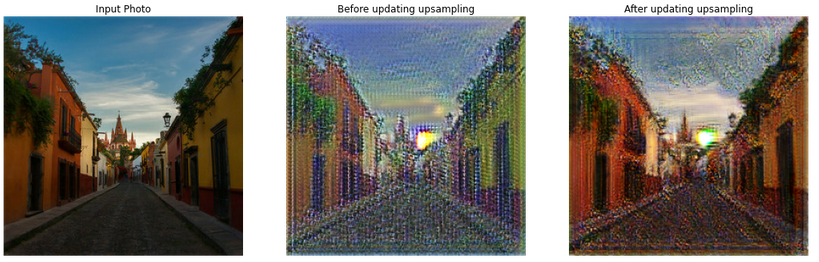

*Figure 4:* comparison of the output before (middle) and after (right) correcting the upsampling architecture. The 'checkerboard' artifacts in the middle image are better in the right image."

### 5.2. Architectural Comparison: ResNet6 vs. ResNet9

After resolving the upsampling artefacts, the next step was to determine the optimal model capacity. We compared two variants of the generator: one with **6 residual blocks** and a deeper version with **9 residual blocks**. Both models utilised the corrected upsampling architecture and were trained for 25 epochs to facilitate a direct comparison. The hypothesis was that a deeper generator could learn more complex stylistic transformations.

The quantitative results were closely matched, but showed significant differences in the final loss values, as shown in the table below.


| Model Variant | Min Cycle Loss | Min Identity Loss | Final Monet Gen Loss |
| :--- | :--- | :--- | :--- |
| 6 ResNet Blocks | **0.2089** | **0.1902** | **60.019** |
| 9 ResNet Blocks | 0.2628 | 0.2425 | 68.608 |


*Table 1:* Loss Comparison for ResNet6 vs. ResNet9 after 25 Epochs

As the table shows, the 6-block model achieved a quantitatively better (lower) score on all key metrics in this specific 25-epoch comparison.

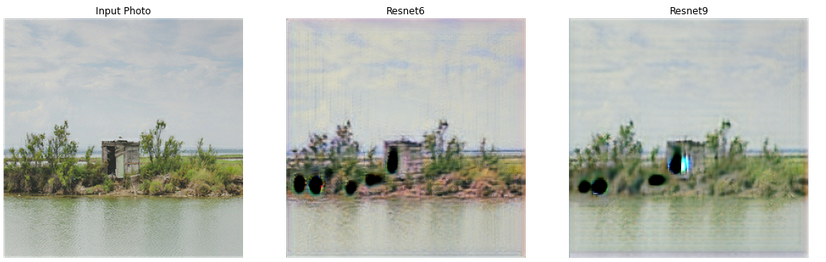

*Figure 5:* Qualitative comparison of generated images from the ResNet6 (left column) and ResNet9 (right column) models.

This presented a conflict: the quantitative results favoured the 6-block model. At the same time, a qualitative review of the generated images suggested the 9-block model had a slight edge in producing better textural detail and more nuanced colour blending.

We decided to proceed with the **9-block architecture** for the final run. This was based on the hypothesis that its greater model capacity, while not fully realised in a short 25-epoch run, would ultimately prove beneficial during a more extended, 100-epoch training session with a more advanced learning rate schedule.


### 5.3. Final Model Training and Results

Following the decision to use the 9-block architecture, we proceeded with a final, extended training run to achieve the best possible performance. Based on the plateauing loss curves in the baseline run, we introduced a **learning rate schedule** and extended the training to **100 epochs**. The learning rate was held constant for the first 50 epochs and then linearly decayed to zero over the final 50 epochs.

This section presents the quantitative results from this definitive run.

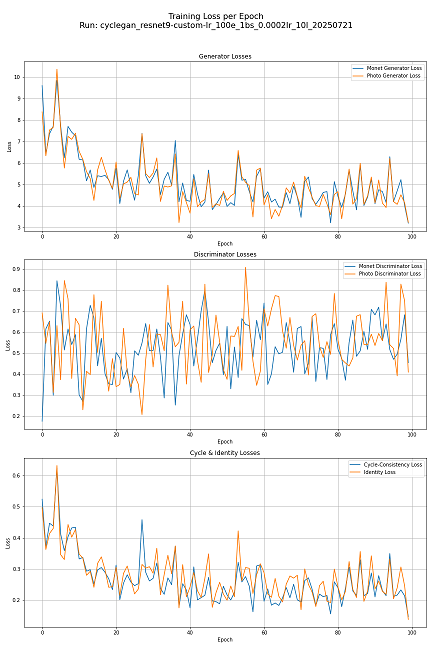

*Figure 6:* Final training loss curves over 100 epochs with the 9-block generator and learning rate decay.

| Training Strategy | Min Cycle Loss | Min Identity Loss | Final Monet Gen Loss |
| :--- | :--- | :--- | :--- |
| 25 Epochs (Static LR) | 0.2628 | 0.2425 | 68.608 |
| 100 Epochs (LR Decay) | **0.1472** | **0.1376** | **32.123** |

*Table 2:* Performance Comparison of ResNet9 with Different Training Strategies

### 5.4. Hyperparameter Tuning: Lambda on ResNet6

As a final experiment, we revisited the 6-block ResNet model. Given that it achieved a better quantitative `cycle_loss` in the initial 25-epoch comparison, we hypothesised that its performance could be further improved by placing more emphasis on content preservation.

To test this, we ran a 100-epoch training session on the **ResNet6** architecture with the `lambda_cycle` value increased from 10 to **20**.

| ResNet6 Variant (100 Epochs) | Min Cycle Loss | Min Identity Loss | Final Monet Gen Loss |
| :--- | :--- | :--- | :--- |
| `lambda = 10` (Baseline) | **0.1449** | **0.1542** | **32.511** |
| `lambda = 20` | 0.1511 | 0.1633 | 70.721 |

*Table 3:* Performance Comparison of ResNet6 with Different Lambda Values


The results indicate that increasing the `lambda` weight to 20 did not improve the primary metrics; in fact, the `Min_Cycle_Loss` and `Min_Identity_Loss` were both slightly better (lower) with the baseline `lambda` of 10.



### 5.4. Qualitative Analysis

While quantitative metrics, such as loss, are essential for tracking training progress, the ultimate measure of a generative model's success is a qualitative assessment of its output. This section presents sample images produced by our final, trained 9-block ResNet generator.

The figure below displays a set of input photographs alongside their corresponding generated Monet-style images. This comparison enables a direct visual evaluation of the model's ability to perform stylistic transfer.

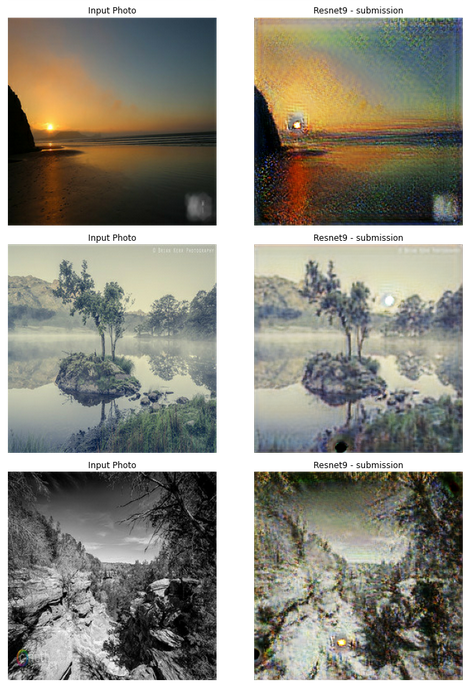


*Figure 7:* sample qualitative results. The left column shows the original input photographs. The right column shows the corresponding output images generated by the final model.

The results demonstrate a successful style transfer. The model effectively captures key elements of Monet's style, including his characteristic colour palette, visible brushstrokes, and the impressionistic treatment of light. The generated images are stylistically consistent and largely free of the artefacts that were present in early iterations. In some images with wonderful details, the model can occasionally simplify the structure more than desired; however, the overall stylistic transformation remains strong.

### 5.5. Kaggle Submission and Score

The final step of the project was to submit an entry for the "I'm something of a painter myself" Kaggle competition. This involved using our final trained generator to translate all the photographs in the test set into the Monet style. The resulting images were then saved and submitted to Kaggle for evaluation.

The competition utilises the Memorisation-informed Fréchet Inception Distance (MiFID) score to evaluate the quality and originality of the generated images [cite: 2]. Our submission achieved a final MiFID score of **68.21**. This is the 45th place, approximately in the top 20%.

In [ ]:

best_path = "/kaggle/input/cycle-gan-monet/cyclegan_resnet9-custom-lr_100e_1bs_0.0002lr_10l_20250721_monet_generator.keras" 
best_gen = tf.keras.models.load_model(best_path)

image_dir = Path('images/')
image_dir.mkdir(parents=True, exist_ok=True)
i = 1
for img in photo_ds:
    prediction = best_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(image_dir / f"{i}.jpg")
    i += 1

output_archive = Path('/kaggle/working/images') 
print(f"Creating archive `{output_archive}`.zip from directory: '{image_dir}'...")

shutil.make_archive(str(output_archive), 'zip', str(image_dir)) 


## 6. Conclusion

### 6.1. Summary of Findings

This project successfully demonstrates that a CycleGAN, refined through a systematic and iterative process, can perform effective unpaired image-to-image translation. The final 9-block ResNet generator, trained for 100 epochs with a custom learning rate schedule, demonstrated the ability to translate photographs into the Monet style with a high degree of stylistic accuracy.

The key finding is that achieving this result required navigating a trade-off between quantitative metrics and qualitative outcomes. While architectural changes successfully resolved initial visual artefacts, the final model selection was guided by a hypothesis about the long-term potential of a deeper network, even when its short-term quantitative scores were weaker. The final generated images capture Monet's characteristic colour and texture, but also reveal limitations in handling specific details and out-of-distribution inputs, which reflect the inherent challenges of the task.

### 6.2. Learnings and Takeaways

The project yielded several important learnings that go beyond simply implementing an architecture:

* **The Conflict Between Metrics and Perception:** The most significant takeaway was the divergence between our primary quantitative metric (`cycle_loss`) and the qualitative assessment of the images. The 6-block ResNet consistently achieved a better cycle loss, yet the 9-block version produced visually superior results. This highlights the limitations of relying on a single metric and underscores the importance of making hypothesis-driven decisions in model development.

* **The Cycle Loss Plateau:** The `cycle_loss` for all models consistently plateaued in a specific range and did not drop further, even with extended training. This suggests an inherent tension in the CycleGAN framework for this task. After a certain point, forcing the model to improve content preservation (lower cycle loss) may actively inhibit its ability to learn the more abstract stylistic transformations.

* **Impact of Architectural and Training Refinements:** The project confirmed the dramatic positive impact of two key changes. First, modifying the upsampling layer was a simple but crucial fix for visual artefacts. Second, implementing a learning rate decay was vital for moving the model beyond the performance plateau observed in shorter, static-rate training runs.

### 6.3. Future Work

The findings, particularly the cycle loss plateau and specific visual artefacts, point to clear directions for future work:

* **Addressing the Cycle Loss Plateau:** Instead of standard L1 loss, one could experiment with a **perceptual loss** (like VGG loss). This type of loss measures differences in a high-level feature space, rather than raw pixels, and may provide a better gradient for improving content preservation without sacrificing style.

* **Improving Detail Reconstruction:** To address the model's struggle with small, high-contrast details (like the sun artefact), incorporating an **attention mechanism** into the generator could be beneficial. Attention would allow the model to focus more on preserving salient regions of the input image.

* **Enhancing Robustness:** To improve performance on out-of-distribution images, the training dataset of photographs could be augmented with a broader variety of images, including pre-processed black and white versions, to make the generator more robust.


## 7. References

[1] Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). *Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks*. In Proceedings of the IEEE International Conference on Computer Vision (ICCV). Available at: [https://arxiv.org/abs/1703.10593](https://arxiv.org/abs/1703.10593)

[2] Jang, A. (2020). *Monet CycleGAN Tutorial*. Kaggle. Retrieved from [https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)

[3] The TensorFlow Authors. (2025). *TensorFlow Documentation*. Retrieved from [https://www.tensorflow.org/api_docs/python/tf](https://www.tensorflow.org/api_docs/python/tf).